In [57]:
#gstat package example

rm(list = ls())
graphics.off()
library(lhs)
library(gstat)
library(sp)
options(warn=-1)
#Problem definition
#Output is 1 if the product of two numbers is larger than 0.75, x1, x2 are both uniformly distributed in [0,1]
Reliability<-function (X) {
  floor(X[ ,1]*X[ ,2]/0.75)
}


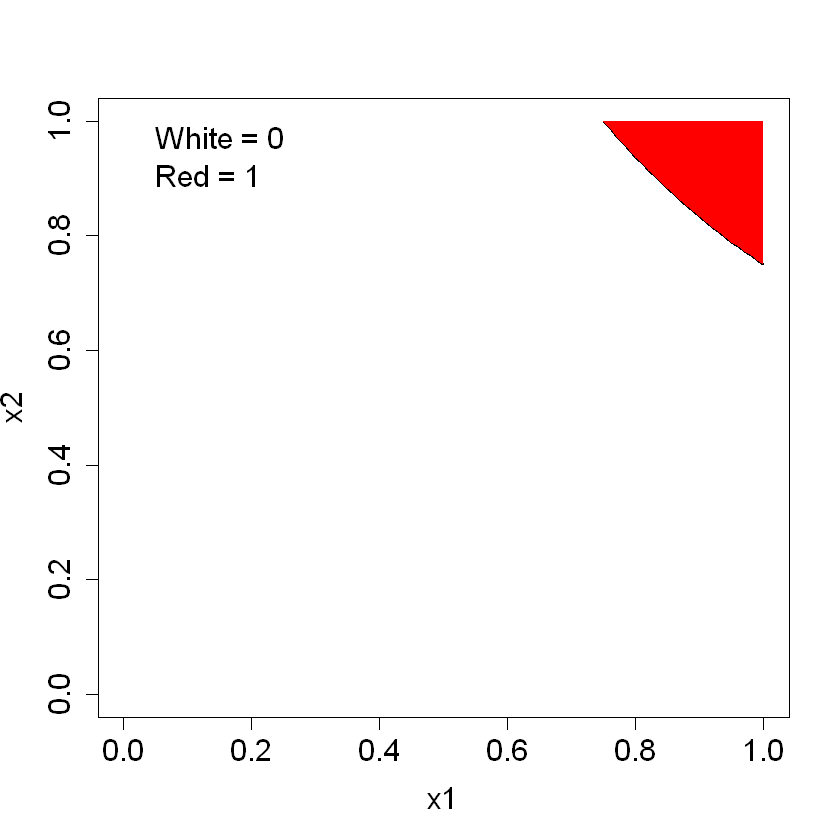

In [58]:
x <- seq(0.75,1,by=0.01)
plot(x,0.75/x,type="l",lwd=2,xlim=c(0,1),ylim=c(0,1),xlab="x1",ylab="x2",cex.lab=1.5,cex.axis=1.5)
polygon(c(0.75,1,rev(x)),c(1,1,rev(0.75/x)),col="red",border = NA)
legend("topleft",legend = c("White = 0", 'Red = 1'),cex = 1.5,bty = "n")

In [59]:
# 100 * 100 = 10000 total points, select 20 as initial samples, fit a Kriging model response to the rest points.
level <- seq(0, 1, length=100)
N <- 10000
X_ALL <- expand.grid(level,level)
Grid <- data.frame(X1=X_ALL$Var1,X2=X_ALL$Var2)
n <- 20
n_init <- n
# take 20 random points from the 10000 points
indx <- sample(N,n)
# x are the used samples
x <- Grid[indx, ]
# X are the rest points to be estimated
X <- Grid[-indx, ]
y <- Reliability(x)
Data <- data.frame(X1=x$X1,X2=x$X2,y=y)
coordinates(Data)=~X1+X2
# Fit a variogram
TheVariogram=variogram(y~1, data=Data)
FittedModel <- fit.variogram(TheVariogram, vgm("Exp"))
TheGStat <- gstat(id="Rel", formula=y ~ 1, data=Data,model=FittedModel )
XX <- X
coordinates(XX) <- ~ X1+X2
# Fit the Kriging surface to the rest points
KrigSurface <- predict(TheGStat, model=FittedModel, newdata=XX)

[using ordinary kriging]


In [60]:
mean <- KrigSurface$Rel.pred
std <- sqrt(KrigSurface$Rel.var)
# P_fail is the estimated failing probability (here define threshold as 0.5: the center point between 0 and 1)
P_fail <- (sum(mean>0.5)+sum(y>0.5))/N
# U is the learning function for the adaptive learning part, each time choose the point with minimum U
# A new sample should be either very close to 0.5 or have a large standard error
U <- abs(mean-0.5)/std
print(c(min(U),P_fail))
if (is.na(P_fail))
  P_fail <- 0
if (is.na(U))
  U <- 0

[1] 0.3956384 0.0001000


In [61]:
# Adaptive sampling
# Stopping threshold is defined as 0.5
while ((min(U)<=0.5) | P_fail==0){
  n <- n+1
  i <- which(U==min(U))
    # Randomly choose a new sample if multiple samples have the same minimum U
  if (length(i)>1){
    i <- sample(i,1)
  }
    # Update new x, y, X
  y <- append(y,Reliability(X[i, ]))
  x <- rbind.data.frame(x,X[i, ])
  X <- X[-i, ]
  XX <- X
  coordinates(XX) <- ~ X1+X2
  Data <- data.frame(X1=x$X1,X2=x$X2,y=y)
  coordinates(Data)=~X1+X2
    # Fit a new variogram and Kriging model
  TheVariogram=variogram(y~1, data=Data)
  FittedModel <- fit.variogram(TheVariogram, vgm("Exp"))
  TheGStat <- gstat(id="Rel", formula=y ~ 1, data=Data,model=FittedModel )
  KrigSurface <- predict(TheGStat, model=FittedModel, newdata=XX)
  mean <- KrigSurface$Rel.pred
  std <- sqrt(KrigSurface$Rel.var)
    # Update new failing probability and learning function
  P_fail <- (sum(mean>0.5)+sum(y>0.5))/N
  if (is.na(P_fail))
    P_fail <- 0
  U <- abs(mean-0.5)/std
  if (is.na(U))
    U <- 0
  print(c(n,min(U),P_fail))
}

[using ordinary kriging]
[1] 21.0000000  0.1459108  0.0002000
[using ordinary kriging]
[1] 2.200000e+01 3.026267e-04 2.000000e-03
[using ordinary kriging]
[1] 2.300000e+01 1.161763e-04 2.720000e-02
[using ordinary kriging]
[1] 24.000000000  0.002430358  0.021200000
[using ordinary kriging]
[1] 25.000000000  0.002729107  0.016200000
[using ordinary kriging]
[1] 26.00000000  0.01475203  0.03050000
[using ordinary kriging]
[1] 27.000000000  0.003758829  0.039100000
[using ordinary kriging]
[1] 28.000000000  0.003458857  0.035100000
[using ordinary kriging]
[1] 29.00000000  0.01894783  0.03220000
[using ordinary kriging]
[1] 30.00000000  0.01960711  0.03350000
[using ordinary kriging]
[1] 31.00000000  0.02225973  0.03540000
[using ordinary kriging]
[1] 32.000000000  0.005577902  0.033100000
[using ordinary kriging]
[1] 33.000000000  0.006928446  0.033700000
[using ordinary kriging]
[1] 34.000000000  0.003414216  0.033200000
[using ordinary kriging]
[1] 35.000000000  0.002215997  0.03410000

ERROR: Error in load.variogram.model(object$model[[name]], c(i - 1, i - 1), max_dist = max_dist): variogram range can never be negative


In [62]:
Grid <- data.frame(X1=X_ALL$Var1,X2=X_ALL$Var2)
coordinates(Grid) <- ~ X1+X2
KrigSurface <- predict(TheGStat, model=FittedModel, newdata=Grid)

colfunc <- colorRampPalette(c("white", "red"))
cols <- colfunc(100)
image.plot(level,level, matrix(KrigSurface$Rel.pred,ncol=100),xaxt="n",yaxt="n", xlab="x1", ylab="x2", col=cols,cex.lab=1.5,cex.axis=1.5)
points(x$X1[1:n_init],x$X2[1:n_init],pch=20,cex=2)
points(x$X1[(n_init+1):n],x$X2[(n_init+1):n],pch=20,cex=2,col="blue")
lines(level,0.75/level,lwd=2)

  model        psill       range
1   Nug 2.338874e-01  0.00000000
2   Exp 1.486860e-12 -0.06124335


ERROR: Error in load.variogram.model(object$model[[name]], c(i - 1, i - 1), max_dist = max_dist): variogram range can never be negative
